# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)  # Box(4,)
print('action space:', env.action_space)  # Discrete(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
# First, we initialize a random policy πθ(a;s)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=100, max_t=1000, gamma=1.0, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # one episode <=> one trajectory
        saved_log_probs = []  # 
        rewards = []
        state = env.reset()
        # using the policy we collect a trajectory
        for t in range(max_t):
            action, log_prob = policy.act(state)
            # collect log(prob[a, s])[Pi-theta]
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        # we compute the total reward of the trajectory
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))  # [21.0, 18.0, 13.0, 10.0, 21.0, 12.0]
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])  # sum of discounted rewards
        # There is no clear credit assignment.
        # A trajectory may contain many good/bad actions and whether these actions are reinforced
        # depends only on the final total output.
        
        policy_loss = []
        # summing over each step
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)  # = g
        # compute g = an estimate of the gradient of the expected reward (U)
        # Pb: The gradient estimate g is very noisy: By chance the collected trajectory
        # may not be representative of the policy.
        policy_loss = torch.cat(policy_loss).sum()
        
        # The update process is very inefficient!
        # We run the policy once, update once, and then throw away the trajectory.
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()  # remember: maximizing the average rewards U(θ)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 10	Average Score: 22.40


KeyboardInterrupt: 

### 4. Plot the Scores

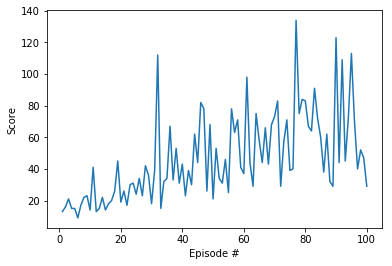

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [10]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')
